1er essaie

---

> # **<u> Projet de Segmentation d’Image Industrielle<u>**
 > ### Détection de Défauts de Pièces Industrielles par Deep Learning

    groupe : Thibault et Julien   
    

### **Objectifs du Projet :**
Dans ce projet, vous allez implémenter une méthode de votre choix en utilisant PyTorch pour effectuer une segmentation d’image afin de détecter des défauts dans des pièces industrielles.

---

## <u>Étape 1 : Charger et Visualiser les Données</u>

Dans cette étape, nous allons explorer le dataset pour mieux comprendre sa structure et son contenu. L'objectif est de nous assurer que les données (images et masques) sont correctement alignées.


##### 1. **Initialiser les chemins et bibliothèques**

Nous définissons les chemins nécessaires pour accéder aux dossiers contenant les images, les masques, et les fichiers `.txt` listant les identifiants des données (`train`, `val`, et `test`).

In [131]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Chemin vers le dossier BSD-SEG
BASE_DIR = "./BSD-SEG"

# Dossiers principaux
ANNOTATIONS_DIR = os.path.join(BASE_DIR, "annotations")
IMGS_DIR = os.path.join(BASE_DIR, "imgs")
LIST_DIR = os.path.join(BASE_DIR, "list")

# Fichiers TXT
TRAIN_LIST = os.path.join(LIST_DIR, "train.txt")
VAL_LIST = os.path.join(LIST_DIR, "val.txt")
TEST_LIST = os.path.join(LIST_DIR, "test.txt")

# Extension des fichiers image
FILE_EXTENSION = ".png"




##### 2. **Charger les fichiers depuis les listes**

Les fichiers `.txt` contiennent les identifiants des images et des masques (sans extensions). Nous utilisons ces listes pour construire les chemins des fichiers correspondants en ajoutant dynamiquement l'extension (par exemple `.png`).


In [132]:
# Fonction pour lire les fichiers de liste et ajouter une extension
def read_list(file_path, file_extension=".png"):
    with open(file_path, "r") as f:
        return [f"{line.strip()}{file_extension}" for line in f.readlines()]

# Charger les listes
train_files = read_list(TRAIN_LIST, FILE_EXTENSION)
val_files = read_list(VAL_LIST, FILE_EXTENSION)
test_files = read_list(TEST_LIST, FILE_EXTENSION)

print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}")


Train files: 298
Validation files: 42
Test files: 86




##### 3. **Visualiser quelques exemples d'images et de masques**

Nous affichons quelques images et leurs masques associés pour vérifier que :
- Les fichiers sont correctement alignés.
- Les masques représentent bien les défauts en blanc (et le reste en noir).


Image path: ./BSD-SEG\imgs\train\417.png
Mask path: ./BSD-SEG\annotations\train\417.png


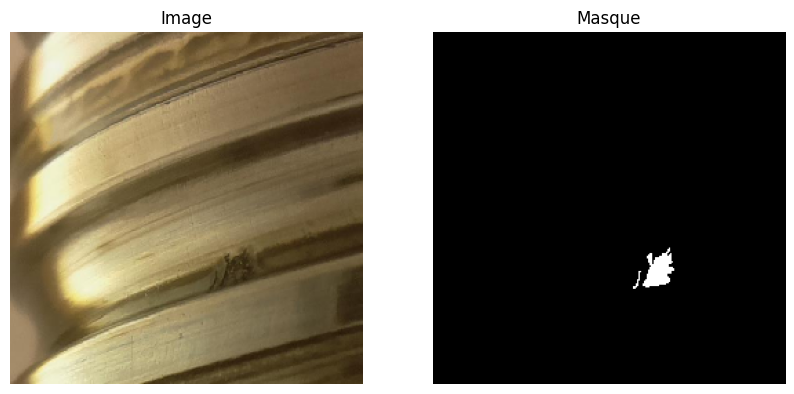

In [133]:
# Fonction pour afficher une image et son masque
def display_example(image_name):
    # Chemins pour l'image et le masque
    img_path = os.path.join(IMGS_DIR, "train", image_name)
    mask_path = os.path.join(ANNOTATIONS_DIR, "train", image_name)

    print(f"Image path: {img_path}")
    print(f"Mask path: {mask_path}")
    
    # Charger l'image et le masque
    try:
        img = Image.open(img_path)
        mask = Image.open(mask_path)
    except FileNotFoundError as e:
        print(f"Erreur : {e}")
        return

    # Afficher l'image et son masque
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(img)
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.title("Masque")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    
    plt.show()

# Exemple
display_example(train_files[0])


---

## <u>Étape 2 : Prétraiter les Données</u>

Dans cette étape, nous préparons les données pour les rendre exploitables par notre modèle. Les images et masques doivent être redimensionnés, normalisés, et convertis en tensors.

##### 1. **Transformer les images et les masques**

Pour que les données soient compatibles avec PyTorch, nous appliquons les transformations suivantes :
- **Images** :
  - Redimensionnement à une taille fixe (par exemple, 256x256).
  - Normalisation des pixels entre -1 et 1.
- **Masques** :
  - Redimensionnement à une taille fixe.
  - Conversion en tensors avec des valeurs binaires (0 pour l'arrière-plan, 1 pour les défauts).


In [134]:
import torch
from torchvision import transforms

# Transformation pour les images
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionner
    transforms.ToTensor(),          # Convertir en tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normaliser entre -1 et 1
])

# Transformation pour les masques
mask_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionner
    transforms.ToTensor()           # Convertir en tensor (0 ou 1)
])




##### 2. **Prétraiter un exemple d'image et de masque**

Nous testons les transformations sur une image et son masque pour vérifier que :
- Les dimensions des tensors sont correctes.
- Les données sont prêtes pour l'entraînement.

In [135]:
def preprocess_example(image_name):
    # Chemins pour l'image et le masque
    img_path = os.path.join(IMGS_DIR, "train", image_name)
    mask_path = os.path.join(ANNOTATIONS_DIR, "train", image_name)

    try:
        img = Image.open(img_path)
        mask = Image.open(mask_path)
    except FileNotFoundError as e:
        print(f"Erreur : {e}")
        return None, None
    
    # Appliquer les transformations
    img_tensor = image_transform(img)
    mask_tensor = mask_transform(mask)

    print(f"Image tensor shape: {img_tensor.shape}")
    print(f"Mask tensor shape: {mask_tensor.shape}")
    
    return img_tensor, mask_tensor

# Exemple
img_tensor, mask_tensor = preprocess_example(train_files[0])


Image tensor shape: torch.Size([3, 128, 128])
Mask tensor shape: torch.Size([1, 128, 128])



---

## <u>Étape 3 : Créer des DataLoaders PyTorch</u>

Dans cette étape, nous allons préparer les données pour qu'elles puissent être utilisées par PyTorch. Les DataLoaders permettent de charger les données en **batches**, de les mélanger si nécessaire, et de les transformer de manière efficace.


##### 1. **Créer un Dataset personnalisé**

Nous allons définir une classe `CustomDataset` qui :
- Charge les images et les masques à partir des chemins donnés.
- Applique les transformations définies pour les redimensionner, normaliser les pixels, et convertir les masques en tensors binaires.
- Permet d'utiliser PyTorch pour charger ces données facilement.


In [137]:
from torch.utils.data import Dataset
from PIL import Image, UnidentifiedImageError
import os

class CustomDataset(Dataset):
    def __init__(self, file_list, img_dir, mask_dir, img_transform=None, mask_transform=None):
        self.file_list = file_list
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform

        # Vérification des fichiers valides
        self.valid_files = []
        for file in self.file_list:
            img_path = os.path.join(self.img_dir, "val", file)
            mask_path = os.path.join(self.mask_dir, "val", file)
            if os.path.exists(img_path) and os.path.exists(mask_path):
                self.valid_files.append(file)
                print(f"Fichier valide ajouté : {file}")
            else:
                print(f"Fichier manquant ou illisible : {img_path} ou {mask_path}")
        
        print(f"Nombre total de fichiers valides : {len(self.valid_files)}")

    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx):
        image_name = self.valid_files[idx]
        img_path = os.path.join(self.img_dir, "val", image_name)
        mask_path = os.path.join(self.mask_dir, "val", image_name)

        print(f"Chemin de l'image : {img_path}")
        print(f"Chemin du masque : {mask_path}")

        try:
            img = Image.open(img_path)
            mask = Image.open(mask_path)
        except Exception as e:
            print(f"Erreur lors du chargement : {e}")
            return None, None

        if self.img_transform:
            img = self.img_transform(img)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return img, mask




##### 2. **Instancier les DataLoaders**

Maintenant que nous avons défini le Dataset personnalisé, nous allons :
- Créer un Dataset pour les données d'entraînement (`train`) et de validation (`val`).
- Créer des **DataLoaders** pour charger les données par lots. Cela nous permettra de gérer efficacement l'entraînement du modèle.

Nous utiliserons un batch size de `8` dans cet exemple, mais cela peut être ajusté en fonction des ressources disponibles (GPU, RAM, etc.).


In [138]:
from torch.utils.data import DataLoader

# Fonction pour vérifier les fichiers existants (n'affecte pas la liste)
def check_files(file_list, img_dir, mask_dir, split):
    for file in file_list:
        img_path = os.path.join(img_dir, split, file)
        mask_path = os.path.join(mask_dir, split, file)
        if not os.path.exists(img_path):
            print(f"Image manquante : {img_path}")
        if not os.path.exists(mask_path):
            print(f"Masque manquant : {mask_path}")

# Vérification des fichiers (uniquement pour affichage)
print("Vérification des fichiers de validation :")
check_files(val_files, IMGS_DIR, ANNOTATIONS_DIR, "val")


# Fonction pour vérifier et filtrer les fichiers valides
def filter_valid_files(file_list, img_dir, mask_dir, split):
    valid_files = []
    for file in file_list:
        img_path = os.path.join(img_dir, split, file)
        mask_path = os.path.join(mask_dir, split, file)
        if os.path.exists(img_path) and os.path.exists(mask_path):
            valid_files.append(file)
        else:
            print(f"Fichier manquant ou illisible : {img_path} ou {mask_path}")
    return valid_files

# Filtrer les fichiers valides
val_files = filter_valid_files(val_files, IMGS_DIR, ANNOTATIONS_DIR, "val")
print(f"Fichiers valides pour la validation : {len(val_files)}")

# Réduction du dataset pour un test rapide
train_files = train_files[:100]  # Limiter à 100 images pour l'entraînement
val_files = val_files[:50]       # Limiter à 50 images pour la validation

# Créer les datasets
train_dataset = CustomDataset(train_files, IMGS_DIR, ANNOTATIONS_DIR, image_transform, mask_transform)
val_dataset = CustomDataset(val_files, IMGS_DIR, ANNOTATIONS_DIR, image_transform, mask_transform)

# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

# Vérifier un batch
for imgs, masks in train_loader:
    print(f"Images batch shape: {imgs.shape}")
    print(f"Masks batch shape: {masks.shape}")
    break


Vérification des fichiers de validation :
Fichiers valides pour la validation : 42
Fichier manquant ou illisible : ./BSD-SEG\imgs\val\417.png ou ./BSD-SEG\annotations\val\417.png
Fichier manquant ou illisible : ./BSD-SEG\imgs\val\83.png ou ./BSD-SEG\annotations\val\83.png
Fichier manquant ou illisible : ./BSD-SEG\imgs\val\106.png ou ./BSD-SEG\annotations\val\106.png
Fichier manquant ou illisible : ./BSD-SEG\imgs\val\137.png ou ./BSD-SEG\annotations\val\137.png
Fichier manquant ou illisible : ./BSD-SEG\imgs\val\325.png ou ./BSD-SEG\annotations\val\325.png
Fichier manquant ou illisible : ./BSD-SEG\imgs\val\198.png ou ./BSD-SEG\annotations\val\198.png
Fichier manquant ou illisible : ./BSD-SEG\imgs\val\380.png ou ./BSD-SEG\annotations\val\380.png
Fichier manquant ou illisible : ./BSD-SEG\imgs\val\346.png ou ./BSD-SEG\annotations\val\346.png
Fichier manquant ou illisible : ./BSD-SEG\imgs\val\200.png ou ./BSD-SEG\annotations\val\200.png
Fichier manquant ou illisible : ./BSD-SEG\imgs\val\205.

ValueError: num_samples should be a positive integer value, but got num_samples=0


---

## <u>Étape 4 : Créer et Configurer le Modèle de Segmentation</u>

Dans cette étape, nous allons définir l'architecture du modèle de segmentation basé sur **UNet**. Cette architecture est particulièrement adaptée aux tâches de segmentation sémantique, grâce à ses chemins descendant et ascendant, ainsi que ses connexions résiduelles (skip connections).


##### 1. **Définir l'architecture UNet**

Le modèle UNet est composé de :
- Un **chemin descendant** (encodeur) qui extrait les caractéristiques de l'image et réduit sa taille spatiale.
- Un **bottleneck** pour comprimer les caractéristiques à une représentation compacte.
- Un **chemin ascendant** (décodeur) qui reconstruit une image segmentée en utilisant les caractéristiques et les connexions résiduelles.



In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        # Chemin descendant (encodeur)
        self.enc1 = self.double_conv(in_channels, 64)
        self.enc2 = self.double_conv(64, 128)
        self.enc3 = self.double_conv(128, 256)
        self.enc4 = self.double_conv(256, 512)
        
        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)
        
        # Chemin ascendant (décodeur)
        self.up4 = self.up_conv(1024, 512)
        self.dec4 = self.double_conv(1024, 512)
        self.up3 = self.up_conv(512, 256)
        self.dec3 = self.double_conv(512, 256)
        self.up2 = self.up_conv(256, 128)
        self.dec2 = self.double_conv(256, 128)
        self.up1 = self.up_conv(128, 64)
        self.dec1 = self.double_conv(128, 64)
        
        # Dernière couche de sortie
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Chemin descendant
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))
        
        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))
        
        # Chemin ascendant
        up4 = self.up4(bottleneck)
        dec4 = self.dec4(torch.cat([up4, enc4], dim=1))
        up3 = self.up3(dec4)
        dec3 = self.dec3(torch.cat([up3, enc3], dim=1))
        up2 = self.up2(dec3)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))
        up1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))
        
        # Sortie
        return torch.sigmoid(self.final(dec1))
    
    @staticmethod
    def double_conv(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    @staticmethod
    def up_conv(in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

# Initialiser le modèle
model = UNet(in_channels=3, out_channels=1)
print(model)


UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): Conv2d(512, 1024, k

##### Explication du code :

1. **Chemin descendant (encodeur)** :
   - Utilise des couches de convolution avec `ReLU` pour extraire les caractéristiques.
   - Réduit la taille spatiale avec des `max_pool2d`.

2. **Bottleneck** :
   - Comprend une couche centrale où les caractéristiques sont compressées avant d'être transmises au décodeur.

3. **Chemin ascendant (décodeur)** :
   - Utilise des convolutions transposées (`ConvTranspose2d`) pour augmenter la taille spatiale.
   - Combine les caractéristiques du décodeur avec celles de l'encodeur via des "skip connections".

4. **Sortie** :
   - Une seule couche de convolution réduit les canaux à `1` (segmentation binaire).
   - La fonction `sigmoid` assure que les sorties sont comprises entre 0 et 1.

5. **Double convolution et convolution transposée** :
   - Les blocs `double_conv` consistent en deux convolutions consécutives pour capturer des caractéristiques plus complexes.
   - Les blocs `up_conv` redimensionnent les cartes de caractéristiques en doublant leur taille.



---

## <u>Étape 5 : Configurer la Fonction de Perte et l'Optimiseur</u>

Dans cette étape, nous allons configurer deux éléments essentiels pour entraîner le modèle :
1. **Fonction de perte** : mesure l'écart entre les prédictions du modèle et la vérité terrain (masques).
2. **Optimiseur** : met à jour les poids du modèle en minimisant la perte calculée.

##### 1. **Définir la fonction de perte**

Pour une tâche de segmentation binaire, la **Dice Loss** est souvent utilisée. Elle mesure la similarité entre les prédictions et les masques, en favorisant une bonne correspondance pour les zones de défaut (classe positive).

La Dice Loss est définie comme suit :

$$
\text{Dice Loss} = 1 - \frac{2 \cdot |A \cap B|}{|A| + |B|}
$$

où \( A \) est la prédiction et \( B \) est le masque.

##### 2. **Définir l'optimiseur**

L'optimiseur est responsable de mettre à jour les poids du modèle à chaque itération. Nous utiliserons **Adam**, un optimiseur efficace et largement utilisé, qui ajuste dynamiquement le taux d'apprentissage.



##### 3. **Combiner fonction de perte et optimiseur**

Nous créons une instance de la fonction de perte et configurons l'optimiseur avec les paramètres du modèle et un taux d'apprentissage (learning rate) initial.

In [50]:
import torch
import torch.nn as nn

# Fonction de perte personnalisée : Dice Loss
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
    
    def forward(self, preds, targets):
        # Appliquer le flatten pour comparer pixel par pixel
        preds = preds.view(-1)
        targets = targets.view(-1)
        
        # Calculer la Dice Loss
        intersection = (preds * targets).sum()
        dice = (2. * intersection) / (preds.sum() + targets.sum() + 1e-6)  # Ajouter un epsilon pour éviter les divisions par 0
        return 1 - dice

# Initialiser la fonction de perte
criterion = DiceLoss()

# Optimiseur Adam avec un taux d'apprentissage initial de 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Afficher les configurations
print("Fonction de perte :", criterion)
print("Optimiseur :", optimizer)


Fonction de perte : DiceLoss()
Optimiseur : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


##### **Explication du code :**

1. **Dice Loss** :
   - La classe `DiceLoss` calcule la perte en comparant les prédictions et les masques après avoir aplati leurs dimensions (pour une comparaison pixel par pixel).
   - L'intersection entre la prédiction et le masque est calculée, et la perte est définie comme \( 1 - \text{Dice Coefficient} \).

2. **Optimiseur Adam** :
   - Adam ajuste automatiquement le taux d'apprentissage pour chaque paramètre du modèle, en fonction des gradients et de leur historique.
   - Nous spécifions un taux d'apprentissage initial de 0.001.



##### **Explications des paramètres :**

- **`amsgrad: False`** : AMSGrad est une variante de l'optimiseur Adam qui modifie la manière dont les gradients sont utilisés pour la mise à jour des poids. Ici, il est désactivé (valeur par défaut).

- **`betas: (0.9, 0.999)`** : Ces paramètres contrôlent les coefficients utilisés pour calculer :
  - Les moyennes mobiles des gradients (\(0.9\)).
  - Les carrés des gradients (\(0.999\)).
  Les valeurs par défaut fonctionnent bien dans la majorité des cas.

- **`eps: 1e-08`** : Une petite valeur ajoutée pour éviter la division par zéro lors du calcul des mises à jour des poids.

- **`lr: 0.001`** : Le taux d'apprentissage initial utilisé pour mettre à jour les poids. Plus il est bas, plus l'entraînement est lent mais stable.

- **`weight_decay: 0`** : Le déclin de poids (régularisation L2) est désactivé. Cela signifie qu'aucune pénalisation pour les poids élevés n'est appliquée.




---

## <u>Étape 6 : Entraîner et Valider le Modèle</u>

Dans cette étape, nous allons :
1. Implémenter une boucle d'entraînement pour optimiser le modèle sur les données d'entraînement.
2. Ajouter une validation périodique pour évaluer les performances sur les données de validation.
3. Suivre les métriques (perte, Dice Score) au fil des époques.


##### 1. **Définir la boucle d'entraînement**

Nous entraînons le modèle sur les données d'entraînement en minimisant la perte.


In [51]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    train_loss = 0
    
    for imgs, masks in dataloader:
        imgs, masks = imgs.to(device), masks.to(device)
        
        # Prédictions et calcul de la perte
        preds = model(imgs)
        loss = criterion(preds, masks)
        
        # Rétropropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    return train_loss / len(dataloader)


**Explications** :
- `model.train()` : Met le modèle en mode entraînement, activant notamment le dropout (si présent).
- Les données (images et masques) sont transférées sur le périphérique spécifié (`CPU` ou `GPU`).
- Le modèle fait des prédictions (`preds = model(imgs)`).
- La perte est calculée entre les prédictions et les masques réels.
- La rétropropagation ajuste les poids pour minimiser cette perte.
- La perte moyenne pour l'époque est retournée.
  
##### 2. **Définir la boucle de validation**

La validation est effectuée sans mise à jour des poids pour évaluer le modèle.


In [52]:
from tqdm import tqdm

# Fonction validate_epoch
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0
    dice_score = 0

    if len(dataloader) == 0:
        print("Le DataLoader de validation est vide.")
        return 0, 0  # Évite la division par zéro

    with torch.no_grad():
        for imgs, masks in tqdm(dataloader, desc="Validation"):
            if imgs is None or masks is None:
                continue

            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = criterion(preds, masks)
            val_loss += loss.item()

            preds = (preds > 0.5).float()
            dice_score += (2 * (preds * masks).sum()) / ((preds + masks).sum() + 1e-6)

    return val_loss / len(dataloader), dice_score / len(dataloader)



**Explications** :
- `model.eval()` : Met le modèle en mode évaluation, désactivant les opérations spécifiques à l'entraînement (comme le dropout).
- `torch.no_grad()` : Désactive le calcul des gradients pour réduire la consommation mémoire et accélérer l'évaluation.
- La fonction retourne la perte moyenne et le Dice Score moyen pour l'époque.



##### 3. **Mettre en place la boucle complète**

Nous avons remcontrès quelques problèmes de rapidité pour le calcul de ce programme, nous avons du faire quelques modifications dans notre code comme de baisser encore plus les dimensions des images (128x128), rajouter tqdm pour avoir un suivi de notre boucle, reduire le batchsize à 4, limiter la taille du dataset pour un test plus rapide...
Nous avons également eu un problème que certains fichier (numero) n'existais. Donc nous avons rajouter le faites d'ignorer les fichiers qui sont manquant quand ça arrive.

Nous combinons les boucles d'entraînement et de validation sur plusieurs époques.


In [53]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5

# Boucle d'entraînement
for epoch in range(num_epochs):
    print(f"\nÉpoque {epoch+1}/{num_epochs}")
    train_loss = 0

    for imgs, masks in tqdm(train_loader, desc=f"Entraînement Époque {epoch+1}"):
        if imgs is None or masks is None:
            continue

        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    val_loss, val_dice = validate_epoch(model, val_loader, criterion, device)
    print(f"  Perte entraînement : {train_loss / len(train_loader):.4f}")
    print(f"  Perte validation : {val_loss:.4f}")
    print(f"  Dice Score validation : {val_dice:.4f}")








Époque 1/5


Entraînement Époque 1: 100%|██████████| 25/25 [01:47<00:00,  4.28s/it]


Le DataLoader de validation est vide.
  Perte entraînement : 0.9649
  Perte validation : 0.0000
  Dice Score validation : 0.0000

Époque 2/5


Entraînement Époque 2:  40%|████      | 10/25 [01:13<01:49,  7.31s/it]


KeyboardInterrupt: 

**Explications** :
- Le modèle est transféré sur le périphérique (`CPU` ou `GPU`) pour l'entraînement et l'évaluation.
- La boucle s'exécute sur plusieurs époques, alternant entraînement et validation.
- À chaque époque :
  - La perte moyenne sur les données d'entraînement est calculée.
  - La perte moyenne et le Dice Score moyen sont calculés sur les données de validation.
- Les performances sont affichées à la fin de chaque époque.

---

### Résumé

À ce stade :
- On à une boucle d'entraînement qui ajuste les poids pour minimiser la perte.
- On valide le modèle périodiquement pour évaluer ses performances et éviter le surajustement.
- Les métriques d'entraînement (perte) et de validation (perte et Dice Score) sont suivies au fil des époques.


test:

In [57]:
for imgs, masks in val_loader:
    print(f"Images batch shape : {imgs.shape}")
    print(f"Masks batch shape : {masks.shape}")
    break
